# Boolean Pandemic 
## Final Project for Machine Learning

This project contains the following sections:

1. Data understanding 
2. Data preprocessing (missing an explanation for hot encoding dummy variables)
3. Feature engineering (pretty much done)
4. Methodology (Radu)
5. Model evaluation and comparison (missing the rest of the models)
    1. Support Vector Machine
        1. Feature Selection
        2. Model Tunning
    2. K Nearest Neighbors
6. Final Result (missing everything)

## 1. Data Understanding

In the following section we will explore the data by looking at descriptive statistics and visualizations, in order to understand our features' distribution, identify outliers, and reveal any data issues (e.g. missing values) that might exist.

In [1]:
import pandas as pd
from plots import *
from dataset import Dataset
from model import Model

C:\Users\Umberto\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

dataset = Dataset()
df = dataset.train_data
print(f"Dataset rows: {df.shape[0]}")
print(f"Dataset columns ({df.shape[1]}):")
for column in list(df.columns):
    print("  - " + column)

Dataset rows: 900
Dataset columns (10):
  - Family_Case_ID
  - Severity
  - Name
  - Birthday_year
  - Parents or siblings infected
  - Wife/Husband or children infected
  - Medical_Expenses_Family
  - Medical_Tent
  - City
  - Deceased


In [3]:
df.describe()

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


These statistics indicate that it suffices to look at `Birthday_Year` and `Medical_Expenses_Family` for potential outliers. The other features do not seem to have any strange values. 

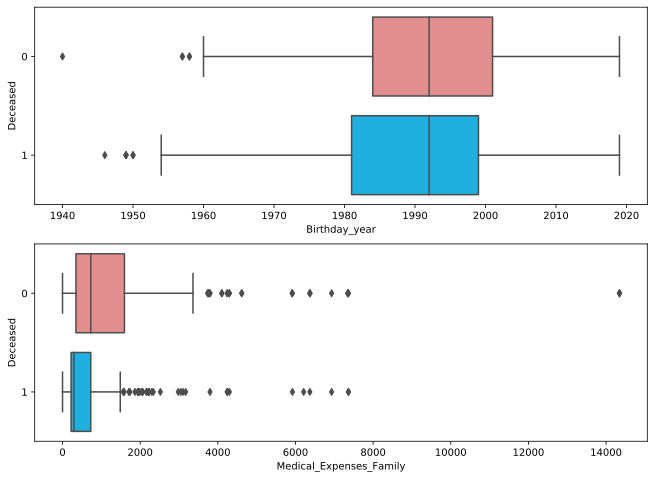

In [4]:
box_plots(df)

**Interpretation**:
- we can see some (potential) outliers in both features
- the `Age` distribution doesn't seem to be that great at separating the target classes, while the `Medical_Expenses_Family` definitely illustrates some differences 

In [5]:
df.isna().sum()

Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [6]:
#pearson_correlation_plot(df)

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

__Interpretation:__
* The highest correlation with `Deceased` have the features `Severity` and `Medical_Expenses_Family`. We will take this into account in the Feature Engineering stage.
* Other features seem to have nearly no correlation with the target.

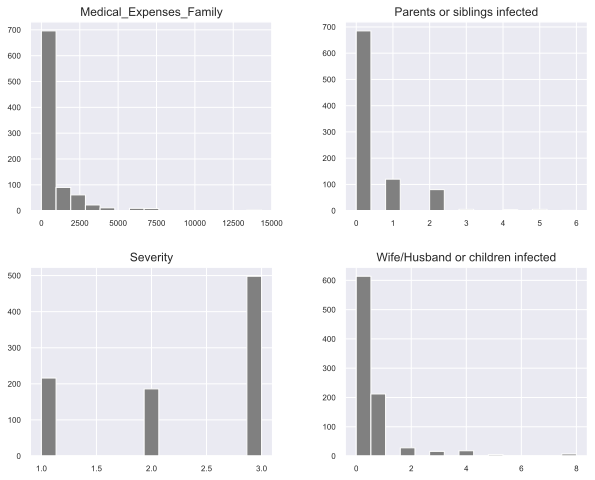

In [7]:
plot_numerical_variables(df)

In [ ]:
family_sizes(df)

In [ ]:
bar_charts_categorical(df, 'City', 'Deceased')

In [20]:
dataset.create_gender()
bar_charts_categorical(df, 'Gender','Deceased')

KeyError: 'Gender'

In [ ]:
bar_charts_categorical(df, 'Medical_Tent','Deceased')

__Interpretation of categorical variables:__
* `Gender`, `City` and `Medical_Tent` seem to have a high class separability. 
* Male patient are proportionally more often deceased than female.
* There are higher deceased proportions in the tents B, D and E.
* Patients from Albuquerque tend to be more often deceased than in other cities.

## 2. Data Preparation

In the following section we will apply some basic transformations to the data.

### 2.1 Deal with empty values

Birthday year and medical tent are the columns with most empty values. To deal with this we decided to just label them as "Empty", for the Tent we set them as N/A, for birthday year as -1.

City has two missing values only, so we can drop them.

In [8]:
df['Medical_Tent'] = df['Medical_Tent'].replace(np.nan, 'n/a', regex=True)
df['Birthday_year'] = df['Birthday_year'].replace(np.nan, -1, regex=True)
df = df[df['City'].notna()]

### 2.2 Convert categorical variables to numeric


In [9]:
## Name is no longer needed
del df['Name']

df_with_categories = pd.get_dummies(df, prefix=['Medical_Tent', 'City', 'Gender'])
for column in list(df.columns):
    print("  - " + column)

ValueError: Length of 'prefix' (3) did not match the length of the columns being encoded (2).

## 3. Feature Engineering

### 3.1 Severity by City

Average severity in the city of the patient.

In [21]:
mean = df[["Severity",'City']].groupby(['City']).mean()
mean["Sev_by_city"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_city"], on='City', how='left')

ValueError: columns overlap but no suffix specified: Index(['Sev_by_city'], dtype='object')

### 3.2 Severity by Tent

Average severity in the medical tent of the patient.

In [11]:
mean = df[["Severity",'Medical_Tent']].groupby(['Medical_Tent']).mean()
mean["Sev_by_tent"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_tent"], on='Medical_Tent', how='left')

### 3.3 Severity by Gender

Average severity whithin the gender of the patient.

In [12]:
mean = df[["Severity",'Gender']].groupby(['Gender']).mean()
mean["Sev_by_gender"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_gender"], on='Gender', how='left')

KeyError: "['Gender'] not in index"

### 3.4 Severity of Family

Average severity in the family of the patient.

In [13]:
mean = df[["Severity",'Family_Case_ID']].groupby(['Family_Case_ID']).mean()
mean["Sev_family"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_family"], on='Family_Case_ID', how='left')

### 3.5 Family Size

Number of patients of a single family in the database.

In [14]:
df["family_size"] = [df.Family_Case_ID.value_counts()[fid] for fid in df.Family_Case_ID.values]

### 3.6 Spending vs. Severity

Medical Expenses Family and Patient's Severity ratio.

In [15]:
df["spending_vs_severity"] = df["Medical_Expenses_Family"] / df["Severity"]

### 3.7 Spending per Family Member

Medical Expenses Family divided by the number of cases in the family.

In [16]:
df["spending_family_member"] = df["Medical_Expenses_Family"] / df["family_size"]

### 3.8 Severity vs. City Average

Patient's severity divided by the city average.

In [17]:
df["severity_against_avg_city"] = df["Severity"] / df["Sev_by_city"]

### 3.9 Severity vs. Gender Average

Patient's severity divided by its gender average.

In [18]:
df["severity_against_avg_gender"] = df["Severity"] / df["Sev_by_gender"]

KeyError: 'Sev_by_gender'

### 3.10 Severity vs. Tent's Average

Patient's severity divided the average in its tent.

In [ ]:
df["severity_against_avg_tent"] = df["Severity"] / df["Sev_by_tent"]

### 3.11 Spending per Member vs. Severity

Spending of a family per member (section 3.6) divided by patient's severity. 

In [ ]:
df["spending_family_severity"] = df["spending_family_member"] / df["Severity"]

## 4. Methodology

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## 5. Model Comparison

### 5.1 First model - Support Vector Machine

In [ ]:
dataset = Dataset()            # Loads the preprocessed dataset
dataset.apply_preparation()    # Applies preprocessing and feature engineering
train_set = dataset.train_data # Training set without labels (train.csv)
target = dataset.target        # Labels for training set     (train.csv[Deceased])
test_set = dataset.test_data   # Unlabeled test set          (test.csv)

#### 5.1.1 Feature Selection and Transformation

By using boxplots, we selected the variables that had more difference when comparing between deceased and alive patients. These boxplots can be found in the object ```model```.

To run boxplots:
```
from model import Model

model = Model()
model.draw_boxplots()
```

To have an equal weight in each of the variables, we apply an standard scaler for our dataset.

In [22]:
from sklearn.preprocessing import StandardScaler

selected_variables_SVC = [
    'Severity',
    'Gender_M',
    'City_Albuquerque',
    'City_Santa Fe',
    "severity_against_avg_gender",
    'Medical_Tent_n/a',
    'spending_family_member',
    'family_size',
    'Sev_family'
]

scaler = StandardScaler().fit(train_set)
train_set = pd.DataFrame(scaler.transform(train_set), columns=train_set.columns)
test_set = pd.DataFrame(scaler.transform(test_set), columns=test_set.columns)

NameError: name 'train_set' is not defined

#### 5.1.2 Model and Results

The class model does the following:

1. Creates and prepares the dataset if no dataset is provided as parameter.
2. Selects a subset of variables to be used for training the model.
3. Splits the dataset into 5-folds for cross validation.
4. Trains five models using the five splits.
5. Keeps the best performing model for prediction.

Using the model provided in the parameters from SKLearn.

In [23]:
from sklearn import svm
from model import Model

# Create classifier from SciKitLearn
svm_model = svm.NuSVC()

model = Model(model     = svm_model,              # Initialized classifier model from SKLearn
              variables = selected_variables_SVC, # Subset of variables from data to be used for training
                                                  # If variables=None, then all variables in set are used
              
              train_set = train_set,              # Samples X for training and validating
              target    = target,                 # Samples Y for training and validating
              test_set  = test_set                # Unlabeled samples for creating prediction
              )                 

model.run_model(path="results/svc_results.csv")

NameError: name 'train_set' is not defined

### 5.2 Second model - K Nearest Neighbors

In [24]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsClassifier(n_neighbors = 5, 
                               weights = 'uniform', 
                               algorithm = 'auto', 
                               leaf_size = 30, 
                               p = 2, 
                               metric='minkowski'
                              )

model_2 = Model(model = knn_model)
model_2.run_model(path="results/knn_results.csv")

Model - KNeighborsClassifier()
Average model accuracy: 78.51%
Highest model accuracy: 82.22%
Solution set saved as 'results/knn_results.csv'.


### 5.3 Third model - Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=3, class_weight={0:1, 1:1.3},criterion="gini",max_depth=10,ccp_alpha=0.0001, random_state=1)

model_3 = Model(model = rf_model, 
                variables= ['Birthday_year', 'Medical_Expenses_Family', 'Sev_by_gender',
                            'Gender_M', 'spending_vs_severity', 'spending_family_member',
                            'severity_against_avg_city', 'spending_family_severity'],
                train_set = train_set,             
                target    = target,                 
                test_set  = test_set)

model_3.run_model(path="results/rf_results.csv")

NameError: name 'train_set' is not defined

### 5.4 Fourth model - GradientBoostingClassifier

In [ ]:
# reload data because I did not use a scaler 

dataset = Dataset()            # Loads the preprocessed dataset
dataset.apply_preparation()    # Applies preprocessing and feature engineering
train_set = dataset.train_data # Training set without labels (train.csv)
target = dataset.target        # Labels for training set     (train.csv[Deceased])
test_set = dataset.test_data   # Unlabeled test set          (test.csv)

In [ ]:
exclude_columns = [
    'Medical_Tent_T'
]

train_set = train_set.loc[:,~train_set.columns.isin(exclude_columns)]

In [ ]:
import xgboost as xgb 

xgb_model = xgb.XGBClassifier(**{'colsample_bylevel': 0.6022636801339624,
                 'colsample_bytree': 0.666571566502976,
                 'gamma': 0.02966833944269946,
                 'learning_rate': 0.5368697534586804,
                 'max_delta_step': 6,
                 'max_depth': 15,
                 'min_child_weight': 0.7475122231419973,
                 'reg_alpha': 3.168702933432126,
                 'reg_lambda': 5.689628963117337,
                 'random_state' : 1234,
                 'subsample': 0.7305056798130244})

model = Model(model     = xgb_model,              # Initialized classifier model from SKLearn
              train_set = train_set,              # Samples X for training and validating
              target    = target,                 # Samples Y for training and validating
              test_set  = test_set                # Unlabeled samples for creating prediction
              )                 

model.run_model(path="results/xgb_results.csv")

### 5.5 Fifth Model - MLPClassifier

In [26]:
from sklearn.neural_network import MLPClassifier 

MLP = MLPClassifier(activation='relu',
                    alpha= 1e-08,
                    batch_size=200,
                    hidden_layer_sizes=(21,21),
                    max_iter= 1500,
                    solver='adam',
                    warm_start=True,
                    random_state=125,
                    beta_2=0.7)

# These are the variables I have selected from the feature selection SelectKBest.
variables = ['spending_vs_severity', 'Medical_Expenses_Family', 'spending_family_severity',
             'spending_family_member', 'Family_Case_ID',
             'Birthday_year', 'Gender_M', 'Severity', 'Sev_family', 'Medical_Tent_B']

model_5 = Model(model = MLP,
               variables= variables)

model_5.run_model(path="results/mlp_results.csv")

Model - MLPClassifier(alpha=1e-08, batch_size=200, beta_2=0.7,
              hidden_layer_sizes=(21, 21), max_iter=1500, random_state=125,
              warm_start=True)
Average model accuracy: 84.19%
Highest model accuracy: 86.59%
Solution set saved as 'results/mlp_results.csv'.
